# Supervised/Hybrid learning on dataset augmented with outliers score

In [1]:
extendend_dataset_selected = False

## Libraries

In [2]:
import h2o
import pandas as pd
import numpy as np

In [3]:
import plotly.graph_objs as go
import plotly
plotly.offline.init_notebook_mode() 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [4]:
import collections

Load selected configuration

In [5]:
if extendend_dataset_selected:
    from extendedgenv import *
else:
    from genv import *

### H2O cluster initialisation

API doc : http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/index.html

In [6]:
h2o.init() # max_mem_size = "4g"

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,56 mins 57 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,5 days
H2O cluster name:,H2O_from_python_pierre_2e44fe
H2O cluster total nodes:,1
H2O cluster free memory:,27.77 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


## Load data

In [7]:
df_train = h2o.import_file(path=DIR_OUTPUT +"train_unbalanced_outlier.csv", col_names=COL_NAME_OUTLIER, col_types=COL_TYPE_OUTLIER)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [8]:
df_validtest = h2o.import_file(path=DIR_OUTPUT +"evaltest_outlier.csv", col_names=COL_NAME_OUTLIER, col_types=COL_TYPE_OUTLIER)

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Exploration

In [9]:
df_train.head(1)

datetime,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,fraud,outlier_autoenc,outlier_pca,outlier_zscore,ensemble_outlier
0,-1.35981,-0.0727812,2.53635,1.37816,-0.338321,0.462388,0.239599,0.0986979,0.363787,0.0907942,-0.5516,-0.617801,-0.99139,-0.311169,1.46818,-0.470401,0.207971,0.0257906,0.403993,0.251412,-0.0183068,0.277838,-0.110474,0.0669281,0.128539,-0.189115,0.133558,-0.0210531,149.62,0,2.10499e-06,0.0627478,0.278364,0.0455621


In [10]:
df_validtest.head(1)

datetime,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,fraud,outlier_autoenc,outlier_pca,outlier_zscore,ensemble_outlier
126397,-0.765586,1.11071,0.497975,-1.24207,0.809253,0.299673,0.352753,0.332642,0.00719612,-1.36338,0.00152343,0.759458,1.21781,-1.42397,-0.316525,1.14988,-0.371549,1.22995,0.55664,-0.0120937,-0.223609,-0.553292,-0.268529,-1.48553,-0.149443,-0.252863,-0.286616,-0.148096,3.79,0,4.87494e-06,0.0353845,0.729109,0


# Models

Here we defined several interchangeable supervised model to be run

## Sampling factor

Deal with unbalanced classification using under-sampling

In [11]:
CLASS_SAMPLING_FACTOR = list([0.01,1.0])

### Random forrest

In [12]:
NTREES = 100

In [13]:
randomforrest = h2o.estimators.random_forest.H2ORandomForestEstimator

In [14]:
randomforrestargs = {"ntrees" : NTREES, 
                     "balance_classes" : True, 
                     "class_sampling_factors" : CLASS_SAMPLING_FACTOR, 
                     "binomial_double_trees" : True,
                     "stopping_metric" : "auc"}

### Gradient boosting

In [15]:
gradientboosting = h2o.estimators.gbm.H2OGradientBoostingEstimator

In [16]:
gradientboostingargs = {"balance_classes" : True, 
                        "class_sampling_factors" : CLASS_SAMPLING_FACTOR, 
                        "stopping_metric" : "auc"}

### Neural networks

In [17]:
lenft = len(X_fraud) # NN input size

In [18]:
neuralnetwork = h2o.estimators.deeplearning.H2ODeepLearningEstimator

In [19]:
neuralnetworkargs = {"hidden" : [lenft*2, lenft*4, lenft*8, lenft*16, lenft*8, lenft*4, lenft],
                     "balance_classes" : True, 
                     "class_sampling_factors" : CLASS_SAMPLING_FACTOR,  
                     "stopping_metric" : "auc"}

## Selection

We select at this point one of the models above (RF or GB or NN)

In [20]:
model = randomforrest
modelargs = randomforrestargs

# Supervised model without any outliers information

Model without the anomaly score

In [21]:
model_simple = model(**modelargs)

In [22]:
model_simple.train(x                = X_fraud, 
                   y                = y_fraud, 
                   training_frame   = df_train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [23]:
print(model_simple)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1495800034122_110


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.057002971756047426
RMSE: 0.23875295130332405
LogLoss: 0.3688770595461154
Mean Per-Class Error: 0.0521833751241898
AUC: 0.9746408844679946
Gini: 0.9492817689359891
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0077386197215977524: 


,0,1,Error,Rate
0,1830.0,8.0,0.0044,(8.0/1838.0)
1,42.0,326.0,0.1141,(42.0/368.0)
Total,1872.0,334.0,0.0227,(50.0/2206.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0077386,0.9287749,77.0
max f2,0.0037231,0.9130435,98.0
max f0point5,0.0360239,0.9627139,60.0
max accuracy,0.0077386,0.9773345,77.0
max precision,0.0360239,0.9936909,60.0
max recall,0.0,1.0,252.0
max specificity,1.0,0.9989119,0.0
max absolute_mcc,0.0077386,0.9168562,77.0
max min_per_class_accuracy,0.0019891,0.9266304,131.0
max mean_per_class_accuracy,0.0037231,0.9478166,98.0


Gains/Lift Table: Avg response rate:  0.20 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101836,0.0053373,98.1971307,98.1971307,0.1955367,0.1955367,1.0,1.0,9719.7130712,9719.7130712
,2,0.0200263,0.0032674,0.0,49.9343421,0.0,0.0994326,0.0,1.0,-100.0,4893.4342070
,3,0.0301937,0.0024851,0.0,33.1195341,0.0,0.0659498,0.0,1.0,-100.0,3211.9534050
,4,0.0401338,0.0020369,0.0,24.9166779,0.0,0.0496157,0.0,1.0,-100.0,2391.6677902
,5,0.0503877,0.0016387,0.0,19.8461125,0.0,0.0395189,0.0,1.0,-100.0,1884.6112543
,6,0.1003588,0.0009739,0.0,9.9642530,0.0,0.0198415,0.0,1.0,-100.0,896.4252979
,7,0.1528838,0.0006357,0.0,6.5409146,0.0,0.0130247,0.0,1.0,-100.0,554.0914561
,8,0.2185036,0.0004151,0.0,4.5765830,0.0,0.0091132,0.0,1.0,-100.0,357.6583046
,9,0.3595914,0.0002033,0.0,2.7809345,0.0,0.0055376,0.0,1.0,-100.0,178.0934467
,10,0.5240007,0.0001007,0.0,1.9083943,0.0,0.0038001,0.0,1.0,-100.0,90.8394345



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2017-05-26 14:57:34,0.008 sec,0.0,nan,nan,nan,nan,nan
,2017-05-26 14:57:34,0.144 sec,1.0,0.2255827,1.7575945,0.9104091,26.2520260,0.0508876
,2017-05-26 14:57:34,0.339 sec,2.0,0.2083755,1.4581009,0.9213363,15.7878899,0.0434473
,2017-05-26 14:57:34,0.562 sec,3.0,0.2033062,1.2912305,0.9266887,94.7882564,0.0414236
,2017-05-26 14:57:34,0.818 sec,4.0,0.1990700,1.1678774,0.9283953,60.6991127,0.0392365
,2017-05-26 14:57:35,1.229 sec,5.0,0.1850400,0.9357815,0.9366753,43.8727672,0.0339152
,2017-05-26 14:57:35,1.892 sec,6.0,0.1905538,0.9742368,0.9359067,97.4243528,0.0355940
,2017-05-26 14:57:36,2.329 sec,7.0,0.1868065,0.8914377,0.9367051,72.8310169,0.0328638
,2017-05-26 14:57:37,2.948 sec,8.0,0.1887078,0.8409664,0.9405281,59.8510629,0.0332410
,2017-05-26 14:57:37,3.507 sec,9.0,0.1911725,0.7719689,0.9438780,49.4136364,0.0312356


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
V17,10052.8740234,1.0,0.1891703
V14,9777.9843750,0.9726556,0.1839976
V10,6137.5122070,0.6105231,0.1154929
V12,4681.5341797,0.4656911,0.0880949
V11,4517.4550781,0.4493695,0.0850074
---,---,---,---
V27,175.5013580,0.0174578,0.0033025
amount,171.2793732,0.0170379,0.0032231
V1,146.8365021,0.0146064,0.0027631
V24,136.2295074,0.0135513,0.0025635



See the whole table with table.as_data_frame()



# Supervised model with outliers score as features

Model with additionals columns, one for each of the anomaly detection techniques tested

In [24]:
model_outliers = model(**modelargs)

In [25]:
model_outliers.train(x                = X_fraud_outlier, 
                     y                = y_fraud, 
                     training_frame   = df_train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [26]:
print(model_outliers)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1495800034122_132


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.04567900953548608
RMSE: 0.2137264829998521
LogLoss: 0.2900708980905961
Mean Per-Class Error: 0.056388489639477735
AUC: 0.9774800874356211
Gini: 0.9549601748712422
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00586973394851451: 


,0,1,Error,Rate
0,1809.0,6.0,0.0033,(6.0/1815.0)
1,41.0,327.0,0.1114,(41.0/368.0)
Total,1850.0,333.0,0.0215,(47.0/2183.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0058697,0.9329529,87.0
max f2,0.0032695,0.9061313,113.0
max f0point5,0.0274823,0.9688264,73.0
max accuracy,0.0058697,0.9784700,87.0
max precision,1.0,1.0,0.0
max recall,0.0,1.0,257.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.0058697,0.9217974,87.0
max min_per_class_accuracy,0.0016374,0.9347826,157.0
max mean_per_class_accuracy,0.0032695,0.9436115,113.0


Gains/Lift Table: Avg response rate:  0.20 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0106002,0.0041997,94.3374170,94.3374170,0.1878509,0.1878509,1.0,1.0,9333.7417050,9333.7417050
,2,0.0209732,0.0029308,0.0,47.6798246,0.0,0.0949432,0.0,1.0,-100.0,4667.9824561
,3,0.0300205,0.0023612,0.0,33.3105624,0.0,0.0663302,0.0,1.0,-100.0,3231.0562365
,4,0.0415190,0.0020115,0.0,24.0853643,0.0,0.0479604,0.0,1.0,-100.0,2308.5364264
,5,0.0526387,0.0017336,0.0,18.9974301,0.0,0.0378289,0.0,1.0,-100.0,1799.7430099
,6,0.1094601,0.0009723,0.0,9.1357457,0.0,0.0181917,0.0,1.0,-100.0,813.5745712
,7,0.1661896,0.0006277,0.0,6.0172240,0.0,0.0119819,0.0,1.0,-100.0,501.7223977
,8,0.2001223,0.0004142,0.0,4.9969446,0.0,0.0099502,0.0,1.0,-100.0,399.6944625
,9,0.3816252,0.0002008,0.0,2.6203723,0.0,0.0052179,0.0,1.0,-100.0,162.0372340
,10,0.5631984,0.0000994,0.0,1.7755733,0.0,0.0035356,0.0,1.0,-100.0,77.5573341



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2017-05-26 14:57:47,0.016 sec,0.0,nan,nan,nan,nan,nan
,2017-05-26 14:57:48,0.377 sec,1.0,0.2224971,1.7098404,0.9100569,32.0528971,0.0495050
,2017-05-26 14:57:48,0.722 sec,2.0,0.2348486,1.7479393,0.9104336,15.3402987,0.0552571
,2017-05-26 14:57:48,1.100 sec,3.0,0.2152835,1.3503858,0.9241747,86.8416636,0.0453154
,2017-05-26 14:57:49,1.527 sec,4.0,0.2092365,1.1632445,0.9320237,52.3117640,0.0429815
,2017-05-26 14:57:49,1.860 sec,5.0,0.2006902,1.0067153,0.9383918,41.7350686,0.0381098
,2017-05-26 14:57:50,2.436 sec,6.0,0.1939296,0.8733814,0.9446291,94.6992391,0.0351048
,2017-05-26 14:57:50,3.007 sec,7.0,0.1890470,0.7502821,0.9503181,69.6222023,0.0328885
,2017-05-26 14:57:51,4.104 sec,8.0,0.1874718,0.6969191,0.9510172,53.6605691,0.0324096
,2017-05-26 14:57:54,6.331 sec,100.0,0.2137265,0.2900709,0.9774801,94.3374170,0.0215300


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
V14,9970.6777344,1.0,0.1825004
outlier_autoenc,9615.8710938,0.9644150,0.1760062
V10,8583.5136719,0.8608756,0.1571102
V12,4823.6054688,0.4837791,0.0882899
V17,3984.6643066,0.3996383,0.0729342
---,---,---,---
V21,171.2130127,0.0171717,0.0031338
V8,157.4195404,0.0157882,0.0028814
V27,151.6410675,0.0152087,0.0027756
outlier_pca,114.8507614,0.0115189,0.0021022



See the whole table with table.as_data_frame()



# Supervised model with outliers ensemble as one feature

Model with only one additional column, the column describing the ensemble of outliers methods (aggregated)

In [27]:
model_ensemble = model(**modelargs)

In [28]:
model_ensemble.train(x                = X_fraud_ensemble_outlier, 
                     y                = y_fraud, 
                     training_frame   = df_train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [29]:
print(model_ensemble)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1495800034122_152


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.044973618853376904
RMSE: 0.21206984428102196
LogLoss: 0.3274650960273324
Mean Per-Class Error: 0.05631841923251213
AUC: 0.9723967898113478
Gini: 0.9447935796226956
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00671732746794254: 


,0,1,Error,Rate
0,1815.0,8.0,0.0044,(8.0/1823.0)
1,41.0,327.0,0.1114,(41.0/368.0)
Total,1856.0,335.0,0.0224,(49.0/2191.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0067173,0.9302987,69.0
max f2,0.0035813,0.9066084,92.0
max f0point5,0.0200181,0.9638554,58.0
max accuracy,0.0067173,0.9776358,69.0
max precision,1.0,1.0,0.0
max recall,0.0,1.0,224.0
max specificity,1.0,1.0,0.0
max absolute_mcc,0.0067173,0.9184503,69.0
max min_per_class_accuracy,0.0015917,0.9293478,133.0
max mean_per_class_accuracy,0.0035813,0.9436816,92.0


Gains/Lift Table: Avg response rate:  0.20 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0102702,0.0050660,97.3693361,97.3693361,0.1938883,0.1938883,1.0,1.0,9636.9336143,9636.9336143
,2,0.0201778,0.0031116,0.0,49.5593993,0.0,0.0986860,0.0,1.0,-100.0,4855.9399303
,3,0.0300584,0.0023131,0.0,33.2685869,0.0,0.0662466,0.0,1.0,-100.0,3226.8586859
,4,0.0400093,0.0017754,0.0,24.9941845,0.0,0.0497701,0.0,1.0,-100.0,2399.4184474
,5,0.0543594,0.0014747,0.0,18.3960780,0.0,0.0366315,0.0,1.0,-100.0,1739.6078041
,6,0.1038651,0.0008587,0.0,9.6278718,0.0,0.0191717,0.0,1.0,-100.0,862.7871842
,7,0.1732077,0.0005199,0.0,5.7734146,0.0,0.0114964,0.0,1.0,-100.0,477.3414558
,8,0.2126380,0.0004117,0.0,4.7028272,0.0,0.0093646,0.0,1.0,-100.0,370.2827188
,9,0.3607223,0.0002017,0.0,2.7722159,0.0,0.0055202,0.0,1.0,-100.0,177.2215889
,10,0.5339300,0.0000998,0.0,1.8729047,0.0,0.0037295,0.0,1.0,-100.0,87.2904717



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2017-05-26 14:58:02,0.012 sec,0.0,nan,nan,nan,nan,nan
,2017-05-26 14:58:03,0.273 sec,1.0,0.2445998,2.0664225,0.8845361,32.5291670,0.0598291
,2017-05-26 14:58:03,0.381 sec,2.0,0.1968104,1.1850626,0.9352942,17.5036178,0.0388350
,2017-05-26 14:58:03,0.786 sec,3.0,0.1919085,1.0595719,0.9362557,83.1882243,0.0345874
,2017-05-26 14:58:03,1.050 sec,4.0,0.1968289,1.0856047,0.9329026,53.0557944,0.0373579
,2017-05-26 14:58:04,1.534 sec,5.0,0.1902667,0.9853576,0.9357905,42.3033513,0.0344304
,2017-05-26 14:58:04,1.869 sec,6.0,0.1939991,0.9736490,0.9367745,93.3530636,0.0346004
,2017-05-26 14:58:05,2.347 sec,7.0,0.1890958,0.9174780,0.9369380,78.2191820,0.0318896
,2017-05-26 14:58:05,2.797 sec,8.0,0.1887521,0.9050501,0.9376778,60.6009278,0.0332397
,2017-05-26 14:58:06,3.381 sec,9.0,0.1885705,0.8397979,0.9402836,96.4019224,0.0310185


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
V14,14256.3271484,1.0,0.2646294
ensemble_outlier,8259.9560547,0.5793888,0.1533233
V17,5569.2075195,0.3906481,0.1033770
V10,5567.4355469,0.3905238,0.1033441
V16,3150.1193848,0.2209629,0.0584733
---,---,---,---
V1,171.1941681,0.0120083,0.0031777
V27,161.5181427,0.0113296,0.0029981
V23,150.9775085,0.0105902,0.0028025
amount,114.4634705,0.0080290,0.0021247



See the whole table with table.as_data_frame()



# Models list

In [30]:
models = collections.OrderedDict([["model_simple", model_simple],
                                  ["model_outliers", model_outliers],
                                  ["model_ensemble", model_ensemble]])

# Results

Here, we go to an overview of all results

## Summary

In [31]:
for m in models:
    print("––––––––––––––– {} –––––––––––––––".format(m))
    print(models[m].summary())

––––––––––––––– model_simple –––––––––––––––
Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,100.0,200.0,180901.0,11.0,20.0,16.425,49.0,82.0,66.22



––––––––––––––– model_outliers –––––––––––––––
Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,100.0,200.0,177878.0,11.0,20.0,16.185,45.0,79.0,64.91



––––––––––––––– model_ensemble –––––––––––––––
Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,100.0,200.0,171279.0,12.0,20.0,16.435,50.0,75.0,62.34


## Confusion matrix

Confusion matrix cheatsheet
![alt text](https://i.stack.imgur.com/ysM0Z.png "CM")

In [32]:
for m in models:
    print("––––––––––––––– {} –––––––––––––––".format(m))
    print(models[m].confusion_matrix(valid=True))

––––––––––––––– model_simple –––––––––––––––
None
––––––––––––––– model_outliers –––––––––––––––
None
––––––––––––––– model_ensemble –––––––––––––––
None


## Variable importance plot

In [33]:
for m in models:
    print("––––––––––––––––––––––––––––––––– {} –––––––––––––––––––––––––––––––––".format(m))
    print(models[m].varimp(use_pandas=True))

––––––––––––––––––––––––––––––––– model_simple –––––––––––––––––––––––––––––––––
     variable  relative_importance  scaled_importance  percentage
0         V17         10052.874023           1.000000    0.189170
1         V14          9777.984375           0.972656    0.183998
2         V10          6137.512207           0.610523    0.115493
3         V12          4681.534180           0.465691    0.088095
4         V11          4517.455078           0.449370    0.085007
5         V16          3652.042725           0.363283    0.068722
6          V3          2865.723633           0.285065    0.053926
7          V4          2013.787598           0.200320    0.037895
8         V18          1692.546143           0.168364    0.031850
9          V7          1452.721680           0.144508    0.027337
10         V9          1107.131836           0.110131    0.020833
11         V2           681.501953           0.067792    0.012824
12         V6           592.541321           0.058942    0.01

In [34]:
for m in models:
    datavar = []
    titleimg = 'Features importance: ' + m
    filenamei = titleimg.lower().replace(" ", "_")
    try:
        varimpo_df = models[m].varimp(use_pandas=True)
    except:
        print("Unable to find variable importance for " + m)
    var_y = varimpo_df["variable"]
    var_x = varimpo_df["scaled_importance"]
    datavar.append(go.Bar(y=var_y[::-1],
                          x=var_x[::-1],
                          orientation = 'h'))

    layout = go.Layout(title = titleimg,
                  xaxis = dict(title = 'Scaled importance'),
                  yaxis = dict(title = ' '),
                  barmode='group',
                  margin=go.Margin(l=150,
                                   r=0,
                                   b=100,
                                   t=100,
                                   pad=4)
    )

    fig = go.Figure(data=datavar, layout=layout)
    plotly.offline.iplot(fig, filename=filenamei, image=IMAGE_FORMAT, image_height=IMAGE_HEIGT, image_width=IMAGE_WIDTH)

## ROC curves plot

In [35]:
rocdata = []

for m in models:
    xroc, yroc = models[m].roc()
    rocauc = models[m].auc()
    rocdata.append(go.Scatter(x=xroc, y=yroc, 
                   mode='lines', 
                   line=dict( width=2),
                   name='%s (area = %0.4f)' % (m,rocauc)))


rocdata.append(go.Scatter(x=[0, 1], y=[0, 1], 
                          mode='lines', 
                          line=dict(color='navy', width=2, dash='dash'),
                          showlegend=False))

layout = go.Layout(title='Receiver operating characteristic (ROC)',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'))

fig = go.Figure(data=rocdata, layout=layout)
plotly.offline.iplot(fig, filename="roc_curves", image=IMAGE_FORMAT, image_height=IMAGE_HEIGT, image_width=IMAGE_WIDTH) # offline method guarantee privacy

## Area under the (ROC) curve

In [36]:
for m in models:
    print("Model '{}' AUC : {}".format(m, models[m].auc()))

Model 'model_simple' AUC : 0.9746408844679946
Model 'model_outliers' AUC : 0.9774800874356211
Model 'model_ensemble' AUC : 0.9723967898113478


Model 'model_simple' AUC : 0.9746408844679946


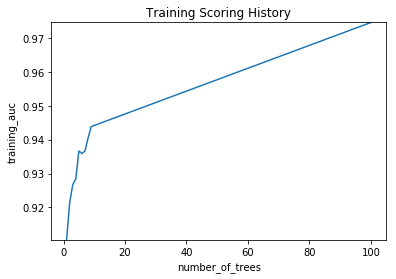

Model 'model_outliers' AUC : 0.9774800874356211


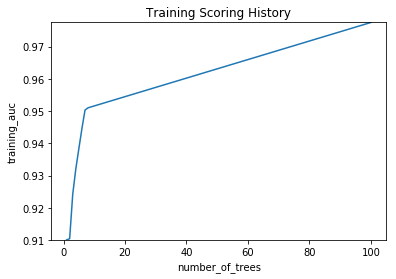

Model 'model_ensemble' AUC : 0.9723967898113478


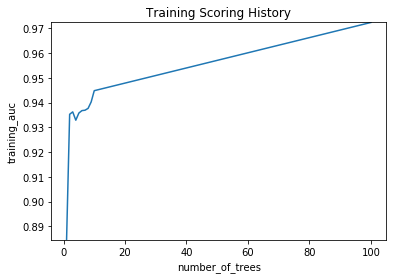

In [37]:
for m in models:
    print("Model '{}' AUC : {}".format(m, models[m].auc()))
    models[m].plot(metric='auc')

# Misc

In [38]:
h2o.cluster().show_status()

H2O cluster uptime:,57 mins 50 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,5 days
H2O cluster name:,H2O_from_python_pierre_2e44fe
H2O cluster total nodes:,1
H2O cluster free memory:,27.69 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [39]:
stopbefore

NameError: name 'stopbefore' is not defined

In [ ]:
h2o.cluster().shutdown()